# Classification of Citrus Diseases

> This notebook covers the necessary steps to experiment with a Neural Network towards a classification problem. We will focus on Citrus leaf diseases, investigating a plain neural architecture to convert input images to a high-dimensional space. In this high-dimensional space, our representation is expected to be sparse and separable into different classes.

We will approach the following:

1. Split our data into training and testing;
2. Configure a dataset (With augmentations);
3. Configure our dataset as a data loader to provide data ingestion during the training phase;
4. Define a Model (Convolutional + Fully Connected);
5. Define a training loop;
6. Define a testing loop;
7. Enable projection of activations (Convolutional and Fully Connected);
8. Run a training experiment and test our model.

## 1. Split our data into training and testing;

Let us first define our dataset; we will explore the citrus leaf diseases, where we want to classify the disease given a leaf image. The cell below imports the necessary libraries.

In [1]:
# Necessary libraries
from pathlib import Path, PosixPath
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
from random import shuffle

First, we need to define the path to our dataset. We are using the Citrus Disease dataset (images have a shape of 256x256 pixels with three channels). To run our experiments, we need to use either a GPU ("cuda") or a CPU ("cpu"); for such, we set the DEVICE variable.

In [2]:
DATA_PATH = Path("../data/citrus_leaves")
IMAGES_FOLDER = DATA_PATH / Path("orig_aug")
CLASSES_DESC = DATA_PATH / Path("classes.txt")
DEVICE = "cuda"

There is a text file describing each of our problem classes.

In [3]:
# Read classes to a dictionary
classes_dict = {}
with open(CLASSES_DESC, "r") as file:
    lines = file.readlines()
    for line in lines:
        class_id, class_description = line.strip().split(" ")
        classes_dict[int(class_id)] = class_description
        
print(classes_dict)

{1: 'blackspot', 2: 'canker', 3: 'greening', 4: 'healthy', 5: 'melanose'}


We have five classes:

1. Blackspot
2. Canker
3. Greening
4. Healthy
5. Melanose

Let's see the name of our images:

In [4]:
image_files = os.listdir(IMAGES_FOLDER)
print(image_files[:10])

['000004_000039.png', '000003_000013.png', '000002_000050.png', '000005_000036.png', '000001_000014.png', '000001_000003.png', '000002_000012.png', '000001_000041.png', '000003_000027.png', '000004_000019.png']


Looking at image folders, we could see that images are organized as follows:

xxxxxx_yyyyyy.png

Where,

- xxxxxx stands for image class;
- yyyyyy stands for image id.

For example, 000003_000024.png stands for an image of class 3 (greening), and 000004_000036.png for an image of class 4 (healthy).

As all images are organized in the same folder, we must split 70%-30% for training and testing, respectively, for each class. The cell below implements this division:

In [5]:
images_by_class = {
    1:[], 2:[], 3:[], 4:[], 5:[]
}

for image_file in image_files:
    image_class = int(image_file.split("_")[0])
    images_by_class[image_class].append(image_file)

    
train_images_by_class = {}
test_images_by_class = {}

for class_id, class_images in images_by_class.items():
    n_train_images = int(0.7 * len(class_images))
    train_images_by_class[class_id] = class_images[:n_train_images]
    test_images_by_class[class_id] = class_images[n_train_images:]

# Merge images back into a single list
train_images = []
for images in train_images_by_class.values():
    train_images += images
shuffle(train_images)
test_images = []
for images in test_images_by_class.values():
    test_images += images
shuffle(test_images)

## 2. Configure a dataset (With augmentations)

Now, we need to define the Dataset Class. It will:

1. Enable training and testing using our data splits.
2. Use augmentations. As we see in segmentation notebooks, sometimes a model performs well in training but poorly in testing. Hence, our model cannot generalize and present an overfitting on training data. A good practice to avoid it is using augmentations on the fly. Using augmentations enables us to modify images in different ways at each epoch.

We start by importing the necessary libraries.

In [6]:
from torch.utils.data import Dataset
from typing import List, Union
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import numpy as np
from torch.utils.data import DataLoader
from PIL import ImageOps
import random

Then, we define our dataset class:

In [7]:
class ClassificationDataset(Dataset):
    def __init__(
        self,
        images_folder: PosixPath, # Path to images
        images: List[str], # List of images
        augmentation: False # Augment or not input images
    ) -> None:
        self.images_path = [images_folder / Path(image) for image in images]
        
        # Sets torch seed to guarantee Reproducibility
        self.random_seed = 7
        torch.manual_seed(self.random_seed)
        torch.cuda.manual_seed(self.random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        if augmentation == True:
            self.transforms = transforms.Compose([
                transforms.RandomAffine(
                    degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                    interpolation=transforms.InterpolationMode.BILINEAR, 
                    fill=0
                ),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ToTensor()
            ])
        else:
            self.transforms = transforms.ToTensor()
        
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, idx):
        image_path = self.images_path[idx]
        label_ = int(image_path.stem.split("_")[0])
        label_one_hot = np.zeros(5)
        label_one_hot[label_ - 1] = 1
        
        random.seed(self.random_seed)
        image = self.transforms(Image.open(image_path))
        label = torch.Tensor(label_one_hot)
        
        return image, label

Finnaly, we define our dataset using all training and testing data.

In [8]:
train_dataset = ClassificationDataset(
    images_folder=IMAGES_FOLDER,
    images=train_images,
    augmentation=True
)
# Augmentation is not necessary for our test data
test_dataset = ClassificationDataset(
    images_folder=IMAGES_FOLDER,
    images=test_images,
    augmentation=False
)

## 3. Configure our dataset as a dataloader

Finally, through PyTorch data loader ([`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)), we configure our dataset as a data loader by using:

- A Dataset (Our Train and Test datasets);
- A batch size (Number of images used to update the model's parameters);
- If we want to shuffle our data at each epoch (We see images in different orders for each epoch).

In [9]:
# DATALOADERS - TRAIN AND TEST

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Visualizes shape of a batch sampled from train dataloder
sample_train_images, sample_train_labels = next(iter(train_dataloader))
print("Images shape => ", sample_train_images.shape)
print("Labels shape => ", sample_train_labels.shape)

Images shape =>  torch.Size([8, 3, 256, 256])
Labels shape =>  torch.Size([8, 5])


Now, let us visualize the output of our dataloader object for a batch. The method `visualize_random_batch` enables us to see a random batch of our data loader:

In [10]:
def visualize_random_batch(dataloader):
    batch_images, batch_labels = next(iter(dataloader))
    
    fig, axes = plt.subplots(2, 4, figsize=(16,8))
    for idx in range(8):
        image = batch_images[idx]
        image = image.transpose(0, 2)
        image = image.detach().cpu().numpy()
        image = (image * 255).astype(np.uint8)
        label = batch_labels[idx]
        label = label.detach().cpu().numpy()
        label = np.argmax(label) + 1
        title = classes_dict[label]
        
        # Plot Data
        axes[idx//4][idx%4].set_yticks([]),axes[idx//4][idx%4].set_xticks([])
        axes[idx//4][idx%4].set_title(title)
        axes[idx//4][idx%4].imshow(image)

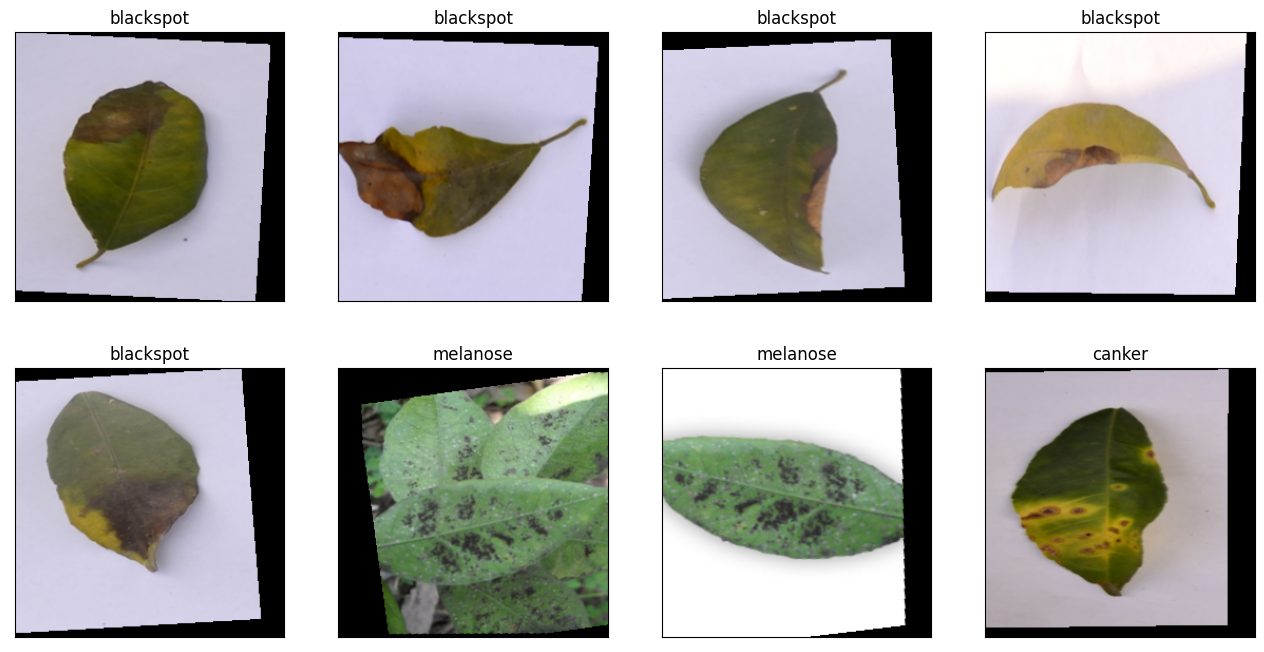

In [11]:
visualize_random_batch(train_dataloader)

## 4. Define a Model (Convolutional + Fully Connected)

Now, we have a dataloader working. It is responsible for feeding data, both the input image and its class ([one-hot encoding](https://en.wikipedia.org/wiki/One-hot)) to a deep learning model. We expect that, given an input image, our model will learn to classify it correctly.

Now, the following cells define our deep-learning model. It has two pieces:

- Encoder: Convolutional and Max-Pooling Layers, responsible for extracting image features.
- Decoder: Fully connected layers responsible for interpreting extracted features and classifying them into one of our five classes.

First, we import necessary libraries.

In [12]:
import torch
from torch import nn
from tifffile import imsave
import torch_snippets

Let us first define a method to help us:

`conv`: Implements a convolutional block with ReLU and MaxPooling.

In [13]:
def conv(
        in_channels:int,
        out_channels:int,
        kernel_size:int,
        padding:int=1
) -> torch.nn.modules.container.Sequential:
    return nn.Sequential(
        nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=1, padding=padding),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)
    )

Now, the class ClassificationModel defines our architecture:

1. On the **__init__** method, we first set a random_seed to guarantee reproducibility. Then, we define our encoder blocks (conv1, conv2, and conv2) and our decoder/classifier (Fully Connected, ReLU, and Droupout);
2. Our **forward** method passes the input image through the model architecture until we get the classification. Additionally, the method `torch.flatten` converts the encoder's output to a 2D tensor (batch, N);
3. **write_activation** and **save_activations** saves activations of each network block for visual inspection;
4. **save_curves** will save the learning curves of our models at the end of our training loop.

To initialize a Classification model, we must set the following parameters:

- `in_channels:` The number of channels of our input (e.g., 3 for RGB and 1 for Gray);
- `n_kernels:` A list of 3 integer values specifying the number of kernels for each convolutional block (e.g., [8, 16,32]).
- `kernel_sizes:` A list of 3 integer values, specifying the kernels' size for each convolutional block (e.g., [3, 3, 3]);
- `fc_neurons:` A list of 2 integers specifying the number of neurons for our 2 Fully-Connected Layers;
- `activations_path:` A path to save each convolutional block activation. After training, one could navigate into that folder to visualize what kind of features the model is extracting.

In [14]:
class ClassificationModel(nn.Module):
    def __init__(
        self, in_channels: int, # RGB or LAB -> 3 Channels
        n_kernels: List[int], # N Kernels by conv block
        kernel_sizes: List[int], # Kernel sizes by conv block
        fc_neurons: List[int], # N Neurons for FC (Fully Connected) Layers
        activations_path: PosixPath = None # Path to save activations
    ) -> None:
        super().__init__()
        self.activations_path = activations_path
        
        # Sets torch seed to guarantee Reproducibility
        random_seed = 7
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        # Classification Encoder        
        self.conv1 = conv(
            in_channels=in_channels, out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0],padding=kernel_sizes[0]//2
        )
        self.conv2 = conv(
            in_channels=n_kernels[0], out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1],padding=kernel_sizes[1]//2
        )
        self.conv3 = conv(
            in_channels=n_kernels[1], out_channels=n_kernels[2],
            kernel_size=kernel_sizes[2],padding=kernel_sizes[2]//2
        )
        
        # Classification Decoder (Classifier)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=32*32*n_kernels[2], out_features=fc_neurons[0]),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(in_features=fc_neurons[0], out_features=fc_neurons[1]),
        )
        
        # Initialize weights (XAVIER)
        self._initialize_weights()
        
    def forward(self, x):
        # List to keep track of activations
        self.activations = []
        
        # Extract Features
        x = self.conv1(x)
        self.activations.append(x)
        x = self.conv2(x)
        self.activations.append(x)
        x = self.conv3(x)
        self.activations.append(x)
        
        #Flattens input tensor into a 2D tensor
        x = torch.flatten(x, start_dim=1)
        
        y = self.classifier(x)
        
        return y
        
    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=np.sqrt(2. / n))
                if m.bias is not None:
                    #initialize bias with 0 
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                #initialize bias with 0 
                    m.bias.data.zero_()
                    
    def write_activation(
        self, image: np.ndarray, path: PosixPath, reshape: bool=False
    ) -> None:
        max_img = np.max(image)
        min_img = np.min(image)
        if (min_img != max_img):
            image = 255 * (image - min_img) / (max_img - min_img)
        image = image.astype(np.uint8)
        
        image = Image.fromarray(image)
        if reshape:
            image = image.resize((256, 256), Image.Resampling.NEAREST)
        image.save(path)
        
    # Save encoder activations
    @torch.no_grad()
    def save_activations(
        self, epoch: int,
        data_loader: torch.utils.data.dataloader.DataLoader
    ) -> None:
        activations_path = self.activations_path / Path(f"epoch_{epoch}")
        
        # Saving activations for each image
        print("[INFO] Saving activations!")
        images_path = data_loader.dataset.images_path
        to_tensor = transforms.ToTensor()
        for image_path in tqdm(images_path):
            image_name = image_path.stem
            saving_path = activations_path / Path(image_name) / Path("encoder")
            saving_path_reshape = activations_path / Path(image_name) / Path("encoder_reshape")
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            
            image_data = to_tensor(Image.open(image_path))
            # Adds Batch Dimension
            image_data = torch.unsqueeze(image_data, dim=0)
            image_data = image_data.to(DEVICE)
            self.to(DEVICE)
            self.forward(image_data)
            
            # Save encoder activations
            for actv_idx, activations in enumerate(self.activations):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]
                    
                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size image
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Save with the same shape as input
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                    )
                    
        # Save model weights
        torch.save(self.state_dict(), activations_path / Path("model.pth"))
        
    def save_curves(self, logger: torch_snippets.torch_loader.Report) -> None:
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(["trn_loss"], ax=ax)
        savefig_path = self.activations_path / Path("loss.png")
        plt.savefig(savefig_path)
        
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(["trn_accuracy"], ax=ax)
        savefig_path = self.activations_path / Path("accuracy.png")
        plt.savefig(savefig_path)

## 5. Define a training loop

We have everything prepared in our pipeline; we lack a training loop, which will feed data from the data loader to our model, and use the model's prediction to compute loss and update the model's parameter.

First, we import the necessary libraries:

In [15]:
from torch_snippets import optim, Report
from torchsummary import summary

Secondly, we define a loss function which we want to optimize. Those loss functions were calculated by comparing the model's predicted class with the ground-truth class mask. To optimize those loss functions is to classify more images correctly.

We will use [Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Additionally, we could set different weights for each class, which helps tackle unbalanced or problematic classes.

> See our slide decks and the link provided for further details.

Our method `criterion` computes a loss and an accuracy for each batch. It also implements [weight decay](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab) and [l2 regularization](https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/l2-regularization).

In [16]:
loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1, 1, 1.5, 1, 1])).to(DEVICE)

# Loss Function with L2 Regularization
def criterion(model, preds, targets, loss_function):
    loss_scalar = loss_function(preds, targets)
    
    # Add l2_regularization
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param, 2)
    loss_scalar += 0.0001 * l2_regularization # 0.0001 is the weight_decay
    # Compute mean accuracy in the batch
    pred_labels = torch.max(preds, 1)[1] # same as argmax
    target_labels = torch.max(targets, 1)[1] # same as argmax
    acc = torch.sum(pred_labels == target_labels)
    n = pred_labels.size(0)
    acc = acc/n
    
    return loss_scalar, acc

Finally, we define our training loop. For such, we must provide:

- The number of epochs to train our model;
- Our Classification Model;
- A data loader;
- Our learning rate (lr), which controls the size of updates in the models' parameters. A too-high value will cause instability, while a too-low value will result in slower training;
- Our loss function;
- And the `n_save_activations`, which controls when we save our convolution activations. For instance, currently, it writes activations for every 200 epochs.

In [17]:
def train_loop(
    epochs, model, dataloader, lr, loss_function,
    n_save_activations=200
):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(DEVICE)
    logger = Report(epochs)
    
    for epoch in range(epochs):
        losses = []
        accuracies = []
        for batch in dataloader:
            model.train()
            image, ground_truth = batch
            image = image.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)
            prediction = model(image)
            optimizer.zero_grad()
            
            # Gets Loss and Accuracy
            loss, acc = criterion(model, prediction, ground_truth, loss_function)
            losses.append(loss)
            accuracies.append(acc)
            
            loss.backward()
            optimizer.step()
        
        mean_loss = torch.mean(torch.Tensor(losses))
        mean_acc = torch.mean(torch.Tensor(accuracies))
        
        logger.record(
            epoch + 1,
            trn_loss=mean_loss.item(),
            trn_accuracy=mean_acc.item()
            )
        if ((epoch + 1) % n_save_activations) == 0:
            model.save_activations(epoch, dataloader)

    model.save_curves(logger)

## 6. Define a testing loop

First, we import necessary libraries

In [18]:
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

The cells below define a method to use our trained model and predict each image class. We also compute metrics between the predicted and the ground truth classes. The following metrics were computed:

- [Accuracy](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
- [cohen kappa score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html)

Additionally, we also show a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). It is a well-known method to assess classification performance. The diagonal represents correct predictions, while other matrix elements indicate the number of images misclassified for each class (with the incorrect prediction).

Finally, a classification report also shows additional metrics, such as [precision, recall, and f1-score](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#precision-recall).

In [19]:
@torch.no_grad()
def predict_and_evaluate(
    model: ClassificationModel,
    data_loader: torch.utils.data.dataloader.DataLoader,
    dataset: str="test"
) -> None:
    images_path = data_loader.dataset.images_path
    preds_path = model.activations_path / Path(f"preds_{dataset}.csv")
    model.eval()
    
    preds_dict = {
        "image_filename": [],
        "ground_truth": [],
        "pred_label": [],
        "prediction": []
    }
    to_tensor = transforms.ToTensor()
    for image_path in tqdm(images_path):
        image_filename = image_path.stem
        ground_truth = int(image_filename.split("_")[0])
        
        image_data = to_tensor(Image.open(image_path))
        # Adds batch dimension
        image_data = torch.unsqueeze(image_data, dim=0)
        image_data = image_data.to(DEVICE)
        prediction = model(image_data).cpu().detach().numpy()[0]
        predicted_label = np.argmax(prediction) + 1
        
        preds_dict["image_filename"].append(image_filename)
        preds_dict["ground_truth"].append(ground_truth)
        preds_dict["pred_label"].append(predicted_label)
        preds_dict["prediction"].append(prediction)
        
    df = pd.DataFrame.from_dict(preds_dict)
    df.to_csv(preds_path, index=False)
    
    # Computes metrics for Multiclass Classification
    print(f"[INFO] Metrics for {dataset} dataset")
    cohen_kappa = cohen_kappa_score(preds_dict["ground_truth"], preds_dict["pred_label"])
    print(f"[INFO] Cohen Kappa Score: {cohen_kappa:.3f}")
    
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(
        preds_dict["ground_truth"],
        preds_dict["pred_label"],
        ax=axs[0]
    )
    axs[0].set_title("Confusion matrix (CM)")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(
        preds_dict["ground_truth"],
        preds_dict["pred_label"],
        ax=axs[1],
        normalize="true", values_format=".0%"
    )
    axs[1].set_title("CM normalized by row")
    plt.show()
    
    report = classification_report(
        preds_dict["ground_truth"],
        preds_dict["pred_label"],
        target_names=list(classes_dict.values())
    )
    print(report)

## 7. Enable projection of activations

We also want to visualize how our transformations (convolutions and fully connected layers) can extract a separable representation of our data. For such a will, we will implement the following:

1. For each image, we will pass it through our whole network;
2. We will store the data transformed after each operation;
3. Given our transformed data, we apply TSNE to extract a representation of our data in two dimensions;
4. We plot each data instance to visualize how separable they are.

In [20]:
from sklearn.manifold import TSNE
from collections import OrderedDict
from typing import Tuple, Dict

In [21]:
def get_each_output(
    model: ClassificationModel,
    x: torch.Tensor
) -> OrderedDict:
    # Empty dict
    output_by_layer = OrderedDict()
    
    # Saves CNN Outputs
    x = model.conv1(x)
    output_by_layer["cnn-1"] = x.clone().detach().cpu().numpy()
    x = model.conv2(x)
    output_by_layer["cnn-2"] = x.clone().detach().cpu().numpy()
    x = model.conv3(x)
    output_by_layer["cnn-3"] = x.clone().detach().cpu().numpy()
    
    #Flattens input tensor into a 2D tensor
    x = torch.flatten(x, start_dim=1)
    
    # Saves Classifier Outputs
    for layer_name, layer in model.classifier.named_children():
        x = layer.forward(x)
        output_by_layer[f"classifier-{layer_name}"] = x.clone().detach().cpu().numpy()
        
    return output_by_layer

def get_outputs(
    model: ClassificationModel,
    data_loader: torch.utils.data.dataloader.DataLoader
) -> Tuple[OrderedDict, np.ndarray]:
    outputs_by_layer = None
    all_labels = None
    
    for inputs, labels in tqdm(data_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.clone().detach().cpu().numpy()
        labels = np.argmax(labels, axis=1) + 1
        
        outputs = get_each_output(model, inputs)
        
        # save the outputs
        if outputs_by_layer == None:
            outputs_by_layer = outputs
            all_labels = labels
        else:
            for layer in outputs:
                outputs_by_layer[layer] = np.concatenate(
                    (outputs_by_layer[layer], outputs[layer]),
                    axis=0
                )
            all_labels = np.concatenate((all_labels, labels))
            
    return outputs_by_layer, all_labels

def visualize_layers_output(
    model: ClassificationModel,
    data_loader: torch.utils.data.dataloader.DataLoader,
    classes_dict: Dict[int, str],
    dataset: str="test"
) -> None:
    print(f"[INFO] Generating visualizations for {dataset} dataset")
    tsne = TSNE(perplexity=12, n_iter=5000)
    outputs_by_layer, all_labels = get_outputs(model, data_loader)
    
    legends = [f"{value} ({key})" for key, value in classes_dict.items()]    
    
    # Projects each layer output into a 2D Space
    cmap = plt.get_cmap('tab10')
    for layer in outputs_by_layer:
        output = outputs_by_layer[layer]
        output = output.reshape(output.shape[0], -1)
        embedded = tsne.fit_transform(output)
        
        for i_label in range(1, 6):
            filtered_embedded = embedded[all_labels==i_label]
            filtered_labels = all_labels[all_labels==i_label]
            points_color = np.array([list(cmap(i_label - 1))] * len(filtered_embedded))
            plt.scatter(
                filtered_embedded[:, 0], filtered_embedded[:, 1],
                c= points_color,
                label=legends[i_label - 1]
            )
        plt.legend(
            loc="lower center", bbox_to_anchor=(0.5, -0.2),
            ncol=3, fancybox=True, shadow=True
        )
        plt.axis("off")
        plt.title(layer)
        plt.show()
           

## 7. Run a training experiment and test our model.

First, we create our model to train. It will use kernel size seven and have an architecture equal to the U-Net image we showed previously.

In [22]:
model = ClassificationModel(
    in_channels=3, n_kernels=[16, 32, 64],
    kernel_sizes=[3, 3, 3], fc_neurons=[256, 5],
    activations_path=DATA_PATH / Path("exper/aug")
)

Then, we run our training loop, using the training data loader defined before:

EPOCH: 1.000  trn_loss: 1.768  trn_accuracy: 0.183  (2.65s - 341.40s remaining)
EPOCH: 2.000  trn_loss: 1.749  trn_accuracy: 0.222  (3.43s - 219.64s remaining)
EPOCH: 3.000  trn_loss: 1.688  trn_accuracy: 0.303  (4.12s - 174.38s remaining)
EPOCH: 4.000  trn_loss: 1.660  trn_accuracy: 0.367  (4.81s - 151.39s remaining)
EPOCH: 5.000  trn_loss: 1.623  trn_accuracy: 0.349  (5.49s - 137.24s remaining)
EPOCH: 6.000  trn_loss: 1.592  trn_accuracy: 0.352  (6.18s - 127.67s remaining)
EPOCH: 7.000  trn_loss: 1.588  trn_accuracy: 0.365  (6.85s - 120.45s remaining)
EPOCH: 8.000  trn_loss: 1.491  trn_accuracy: 0.389  (7.54s - 114.92s remaining)
EPOCH: 9.000  trn_loss: 1.461  trn_accuracy: 0.416  (8.22s - 110.52s remaining)
EPOCH: 10.000  trn_loss: 1.481  trn_accuracy: 0.390  (8.90s - 106.84s remaining)
EPOCH: 11.000  trn_loss: 1.481  trn_accuracy: 0.365  (9.60s - 103.84s remaining)
EPOCH: 12.000  trn_loss: 1.437  trn_accuracy: 0.399  (10.29s - 101.16s remaining)
EPOCH: 13.000  trn_loss: 1.399  trn_

100%|██████████████████████████████████████| 231/231 [00:00<00:00, 67925.14it/s]


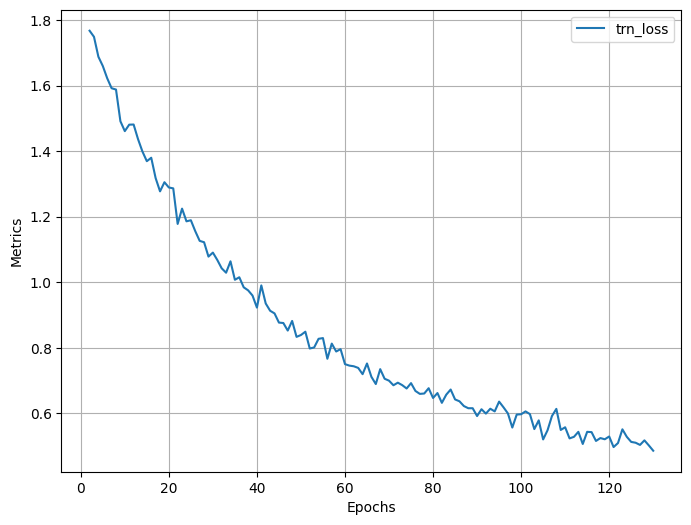

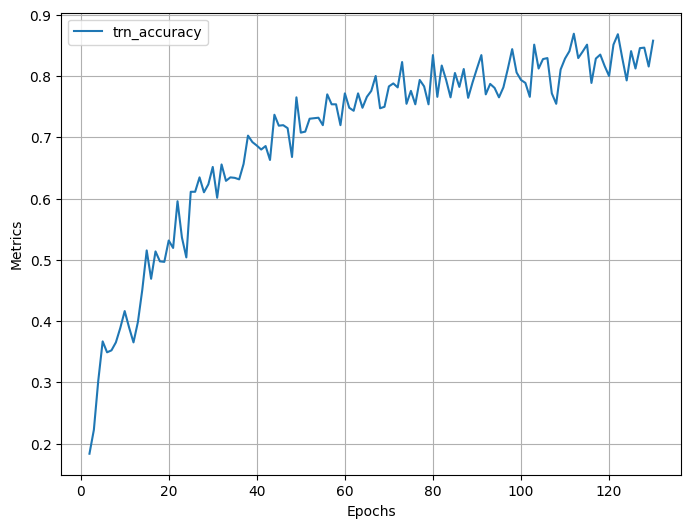

In [23]:
train_loop(130, model, train_dataloader, 1e-5, loss_function, 130)

We run our testing method (`predict_and_evaluate`) for the trained model, using the training and testing data.

100%|████████████████████████████████████████| 175/175 [00:00<00:00, 387.13it/s]


[INFO] Metrics for train dataset
[INFO] Cohen Kappa Score: 0.850


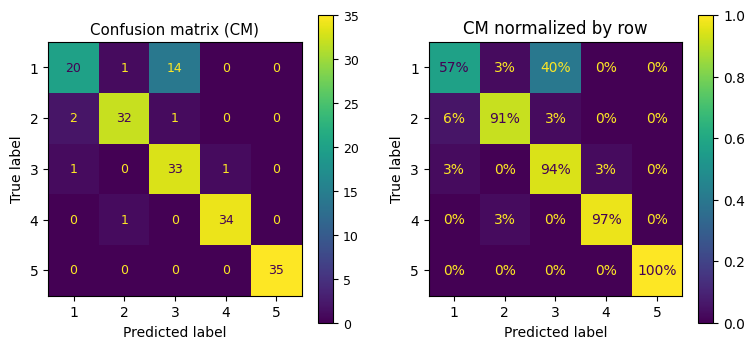

              precision    recall  f1-score   support

   blackspot       0.87      0.57      0.69        35
      canker       0.94      0.91      0.93        35
    greening       0.69      0.94      0.80        35
     healthy       0.97      0.97      0.97        35
    melanose       1.00      1.00      1.00        35

    accuracy                           0.88       175
   macro avg       0.89      0.88      0.88       175
weighted avg       0.89      0.88      0.88       175



In [24]:
predict_and_evaluate(
    model=model,
    data_loader=train_dataloader,
    dataset="train"
)

100%|██████████████████████████████████████████| 75/75 [00:00<00:00, 367.31it/s]


[INFO] Metrics for test dataset
[INFO] Cohen Kappa Score: 0.767


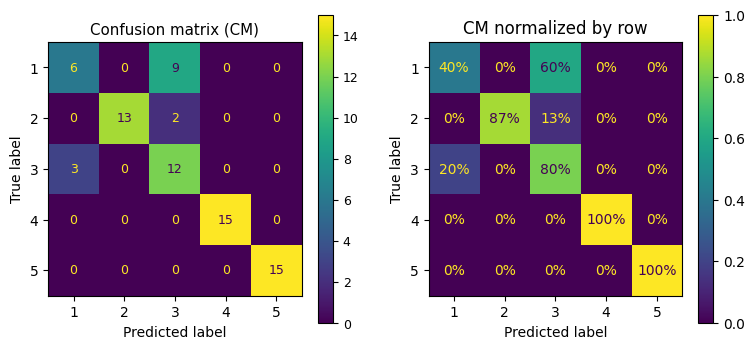

              precision    recall  f1-score   support

   blackspot       0.67      0.40      0.50        15
      canker       1.00      0.87      0.93        15
    greening       0.52      0.80      0.63        15
     healthy       1.00      1.00      1.00        15
    melanose       1.00      1.00      1.00        15

    accuracy                           0.81        75
   macro avg       0.84      0.81      0.81        75
weighted avg       0.84      0.81      0.81        75



In [25]:
predict_and_evaluate(
    model=model,
    data_loader=test_dataloader,
    dataset="test"
)

Finnaly, we visualize each layer outputs (For training and test):

[INFO] Generating visualizations for Train dataset


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 16.59it/s]
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


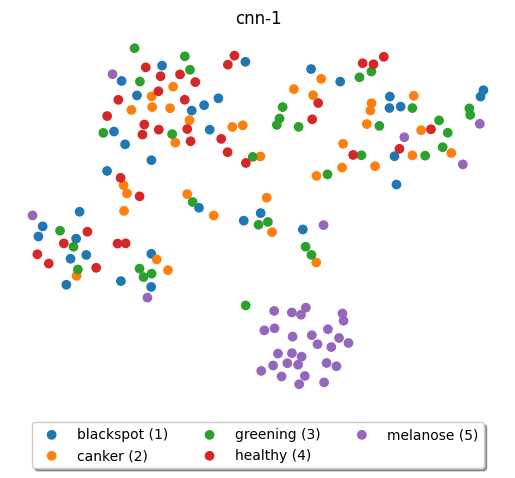

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


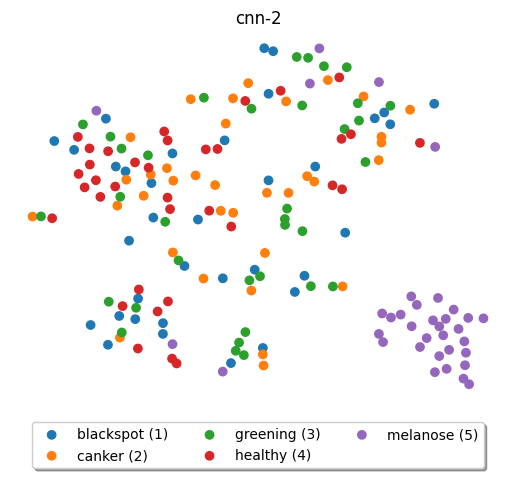

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


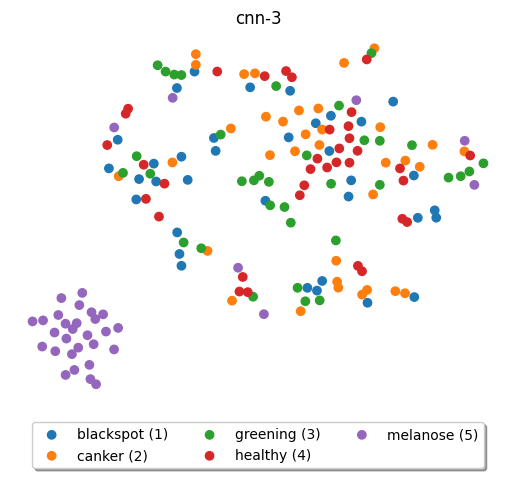

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


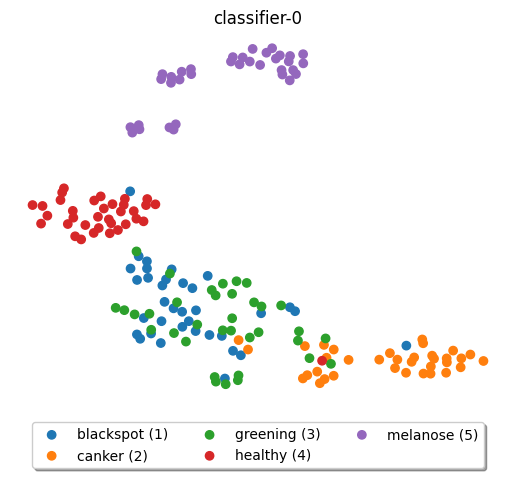

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


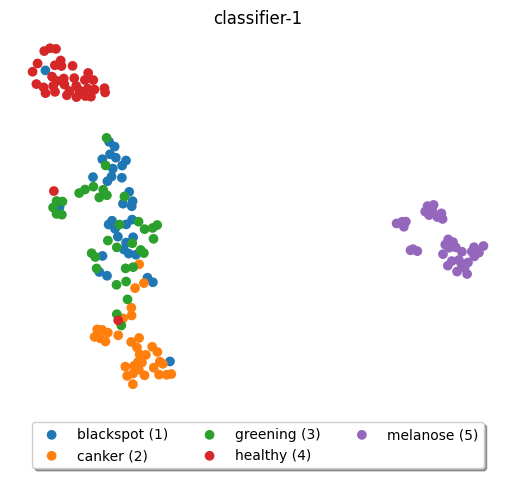

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


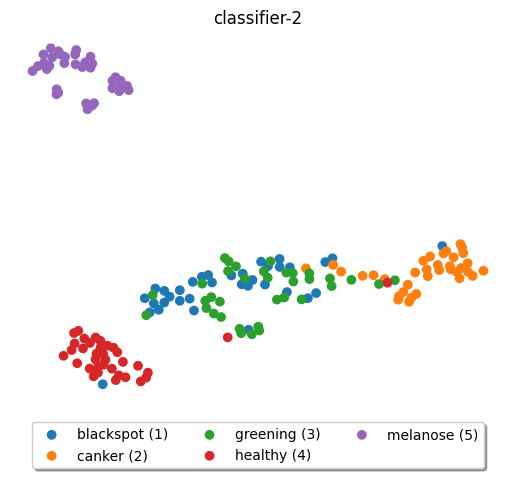

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


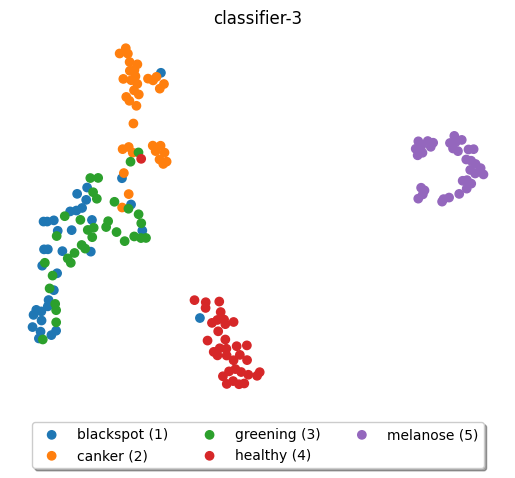

In [26]:
visualize_layers_output(
    model=model,
    data_loader=train_dataloader,
    classes_dict=classes_dict,
    dataset="Train"
)

[INFO] Generating visualizations for Test dataset


100%|███████████████████████████████████████████| 75/75 [00:01<00:00, 74.58it/s]
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


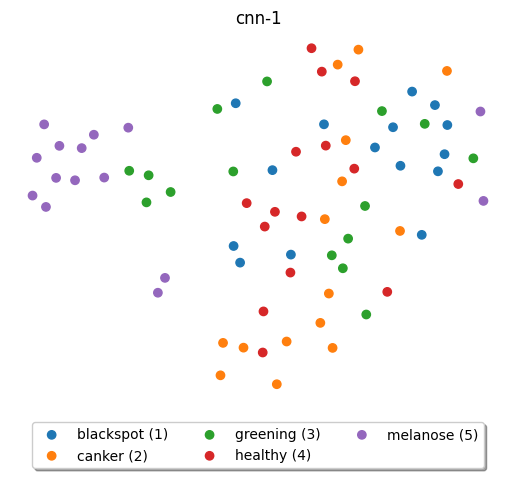

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


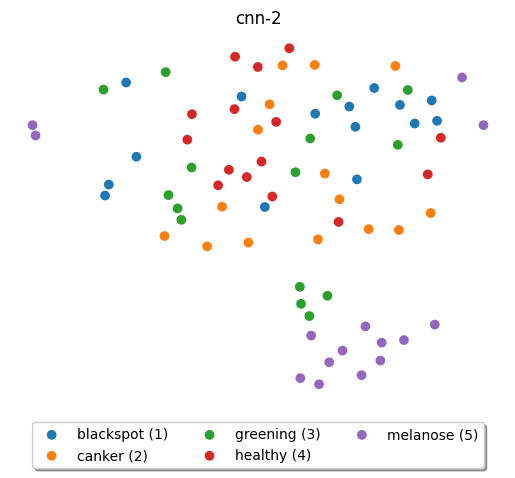

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


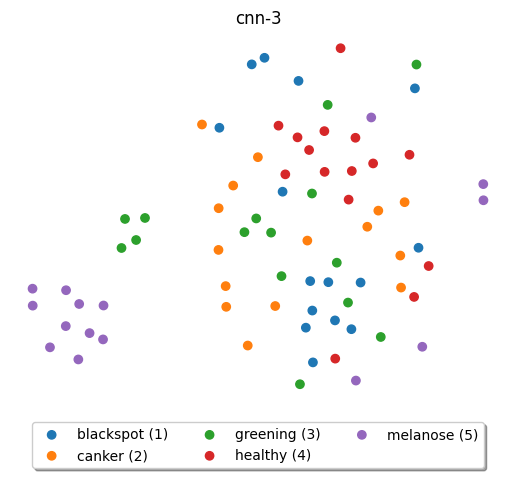

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


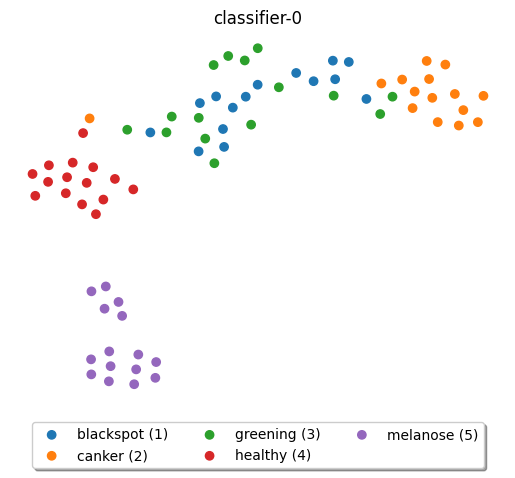

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


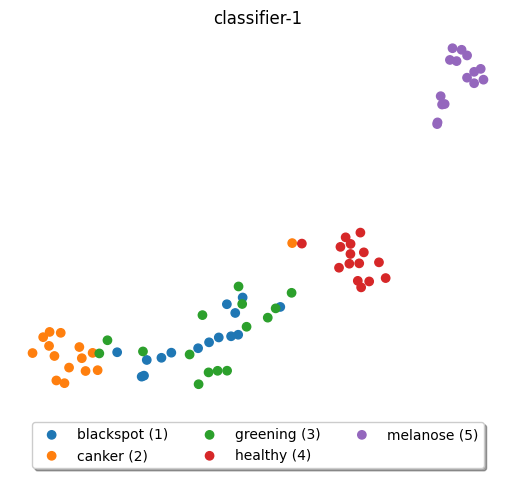

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


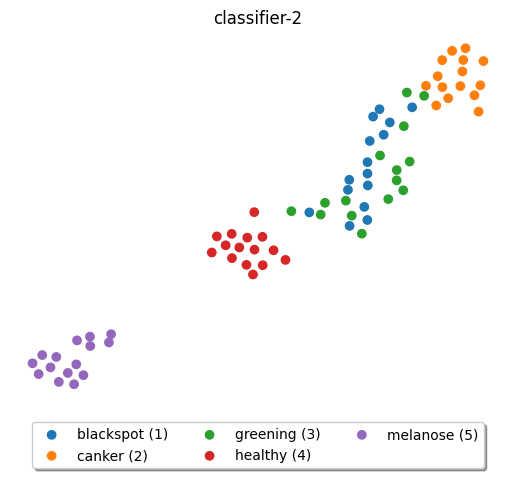

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


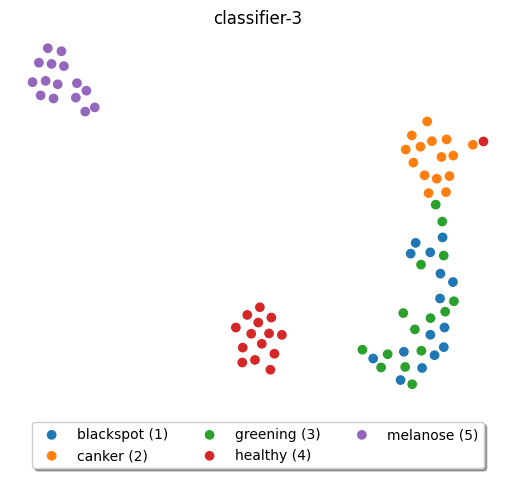

In [27]:
visualize_layers_output(
    model=model,
    data_loader=test_dataloader,
    classes_dict=classes_dict,
    dataset="Test"
)

The visualization of layer's outputs confirms what our classification matrix show us. Our model struggles to classify blackspot image. Most of blackspot image are wrongly classified as greening (This is something that we already tries to solve, by seeting classes weights). Try to improve it.

# Extra - Activities

- Try different classes weights (cross entropy loss) and verify if you can improve model's performance for all classes
- Modify augmentations and verify if you improve model's generalization
- Test different configurations for your model (e.g., number of filters, filters size, number of neurons for the hidden layer) and verify if you can improve model's performance
- Verify if you can improve separability of classes on the projections (Classifiers)